In [2]:
!pip install -U -q langgraph langchain langchain-openai langchain-community faiss-cpu arize-phoenix


In [3]:
!pip install -q openai openinference-instrumentation-langchain


**Evaluation of Agents**

Following the agentic workflow notebook https://github.com/ramnarayan-code/llm_agents/blob/main/Agentic_workflow_playbook.ipynb, let's evaluate the performance of the Organisation chatbot agent using Phoenix(https://docs.arize.com/phoenix), an open-source observability library designed for experimentation, evaluation, and troubleshooting. 

**Pre-requisites:**
1. Install all the required packages(langchain, langgraph and phoenix) preferrably via Conda package manager
2. Start Phoenix server(Default port: 6006) using the command "phoenix serve"
 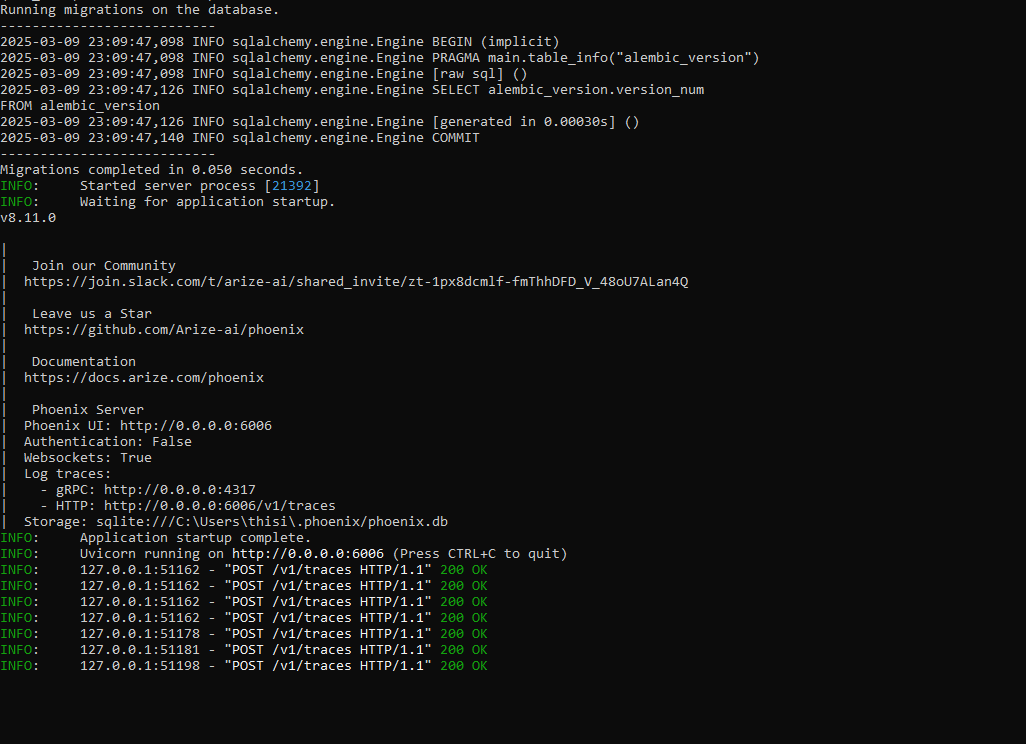

In [4]:
import os
import sqlite3

import langgraph
import phoenix as px
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from typing import Annotated, Any, Dict, Optional, Sequence, TypedDict, List, Tuple
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, StateGraph
from phoenix.otel import register
from openinference.instrumentation.langchain import LangChainInstrumentor


C:\Users\thisi\miniconda3\envs\llm_eval\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.environ["OPENAI_API_KEY"] = ""

**Set-up tracing for Langchain based RAG and Agents**

In [6]:
tracer_provider = register(
  endpoint= "http://localhost:6006/v1/traces",
  auto_instrument=True
)

OpenTelemetry Tracing Details
|  Phoenix Project: default
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [7]:
LangChainInstrumentor(tracer_provider=tracer_provider).instrument(skip_dep_check=True)

Attempting to instrument while already instrumented


**Define an observability project with phoenix server endpoint**

In [8]:
px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [9]:
tracer = tracer_provider.get_tracer(__name__)
tracer

**RAG Based Department Navigator**

In [10]:
class LLMRAGBasedNavigator:
    def __init__(self):
        self.__model = ChatOpenAI()
        self.__navigator_prompt_template = template = """
                    You are a department navigator. Provide the department location based on the context:
                    {context}

                    Question: {question}
                  """

    def __create_retreiver(self, context):
        self.__vectorstore = FAISS.from_texts(context, embedding=OpenAIEmbeddings())
        self.__retriever = self.__vectorstore.as_retriever()


    def __create_prompt(self):
        self.__prompt = ChatPromptTemplate.from_template(self.__navigator_prompt_template)

    def get_retriever(self):
        return self.__retriever

    def create_llm_chat_context(self, context):
        self.__create_retreiver(context)
        self.__create_prompt()
        self.__llm_chain = (
            {"context": self.__retriever, "question": RunnablePassthrough()}
            | self.__prompt
            | self.__model
            | StrOutputParser()
        )

    @tracer.chain()
    def chat_with_llm(self, question):
        response = self.__llm_chain.invoke(question)
        return response

context_for_department_navigation =  ["HR is located on the first floor",
                                  "Finance is located on the second floor",
                                  "Data & Analytics is located on the third floor",
                                  "Sales is located on the fourth floor",
                                  "Marketing is located on the fifth floor"]
llm_navigator = LLMRAGBasedNavigator()
llm_navigator.create_llm_chat_context(context_for_department_navigation)


**Organisation chatbot agent**

In [11]:
class Agent:
  def __init__(self, prompt, tools, model):
    self.__system_message = prompt
    self.__tools = tools
    self.__model = model
    self.__memory = MemorySaver()

  def create(self):
    self.__agent = create_react_agent(self.__model, self.__tools, state_modifier=self.__system_message, checkpointer=self.__memory)

  def invoke(self, input, config=None):
    return self.__agent.invoke({"messages": input}, config)["messages"][-1].content

In [ ]:

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except sqlite3.Error as e:
        print(e)
    return conn

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except sqlite3.Error as e:
        print(e)

def insert_employee(conn, employee):
    sql = ''' INSERT INTO employee(id, name, designation)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, employee)
    conn.commit()
    return cur.lastrowid

def insert_reporting(conn, reporting):
    sql = ''' INSERT INTO reporting(id, manager_id)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, reporting)
    conn.commit()
    return cur.lastrowid

def main():
    database = "org.db"

    sql_create_employee_table = """ CREATE TABLE IF NOT EXISTS employee (
                                        id integer PRIMARY KEY,
                                        name text NOT NULL,
                                        designation text NOT NULL
                                    ); """

    sql_create_reporting_table = """ CREATE TABLE IF NOT EXISTS reporting (
                                        id integer NOT NULL,
                                        manager_id integer,
                                        FOREIGN KEY (id) REFERENCES employee (id)
                                    ); """

    conn = create_connection(database)

    if conn is not None:
        create_table(conn, sql_create_employee_table)
        create_table(conn, sql_create_reporting_table)

        employees = [(1, 'Alice', 'CEO'),
                     (2, 'Bob', 'CTO'),
                     (3, 'Charlie', 'COO'),
                     (4, 'David', 'CFO'),
                     (5, 'Eve', 'Head of Data & Analytics'),
                     (6, 'Fred', 'HR Head')]

        reportings = [(2, 1),  # Bob reports to Alice
                      (3, 1),  # Charlie reports to Alice
                      (4, 1),  # David reports to Alice
                      (5, 2),  # Eve reports to Bob
                      (6, 3)] # Fred reports to Charlie

        for employee in employees:
            insert_employee(conn, employee)

        for reporting in reportings:
            insert_reporting(conn, reporting)

        print("Database created and tables populated successfully.")
    else:
        print("Error! Cannot create the database connection.")

if __name__ == '__main__':
    main()


In [13]:
from langchain_core.tools import tool

@tracer.tool()
def get_employees():
  """Gets the employees list."""
  conn = create_connection("org.db")
  employees = {}
  try:
      cur = conn.cursor()
      cur.execute("""
          SELECT e.id, e.name, e.designation, r.manager_id, m.name as manager_name
          FROM employee e
          LEFT JOIN reporting r ON e.id = r.id
          LEFT JOIN employee m ON r.manager_id = m.id
      """)
      rows = cur.fetchall()
      for row in rows:
          emp_id, name, designation, manager_id, manager_name = row
          employees[emp_id] = {
              "name": name,
              "designation": designation,
              "manager_id": manager_id,
              "manager_name": manager_name
          }
  except sqlite3.Error as e:
      print(e)
  return employees

In [14]:
class AgentState(TypedDict):
    query: Sequence[BaseMessage]
    result: str

In [15]:
model = ChatOpenAI(model="gpt-4o")

In [16]:
# Based on LLM agent with tools
@tracer.chain()
def org_chatbot(state):
    print(f'Org agent:')
    query = state['query']
    prompt = """
      You are an Organisation chatbot. Follow the below rules:
      1. When you get questions about employees and their reporting structure, call get_employees tool
      2. When you get questions about departments, route the query to "department_navigator" agent
    """
    tools = [get_employees]
    organisation_chatbot_agent = Agent(prompt, tools, model)
    organisation_chatbot_agent.create()
    config = {"configurable": {"thread_id": "test-thread"}}
    result = organisation_chatbot_agent.invoke([("user", query)], config)
    return {'result': result}

# Routing the department location questions to RAG agent "department_navigator"
@tracer.chain()
def route(state):
    result = state['result']
    if "department_navigator" in result:
        return "department_navigator"
    else:
        return END

# Based on RAG agent
@tracer.chain()
def department_navigator(state):
    print(f'department_navigator agent:')
    query = state['query']
    result = llm_navigator.chat_with_llm(query)
    return {'result':result}

In [17]:

workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("org_chatbot", org_chatbot)
workflow.add_node("department_navigator", department_navigator)

# Build graph
workflow.set_entry_point("org_chatbot")
workflow.add_conditional_edges("org_chatbot", route)
workflow.add_edge("org_chatbot", END)

app = workflow.compile()


In [18]:

print("Welcome to Virtual Org!. I am Virtual Org Chatbot. I can answer to both general and company-specific questions")

while True:
  query_input = input('Enter the query: ')
  if query_input == 'exit':
    print("See you next time...")
    break

  for stream_msg in app.stream({"query": query_input}):
    if "__end__" not in stream_msg:
        if "org_chatbot" in stream_msg:
          print(stream_msg["org_chatbot"])
        elif "department_navigator" in stream_msg:
          print(stream_msg["department_navigator"])
        print("----")


Welcome to Virtual Org!. I am Virtual Org Chatbot. I can answer to both general and company-specific questions


Enter the query:  where is finance department located?


Org agent:
{'result': 'For information about the location of the finance department, please refer to the "department_navigator" agent.'}
----
department_navigator agent:
{'result': 'The finance department is located on the second floor.'}
----


Enter the query:  how many employees?


Org agent:
{'result': 'The organization has a total of 6 employees.'}
----


Enter the query:  exit


See you next time...


**Trace of Agent workflow in Phoenix**

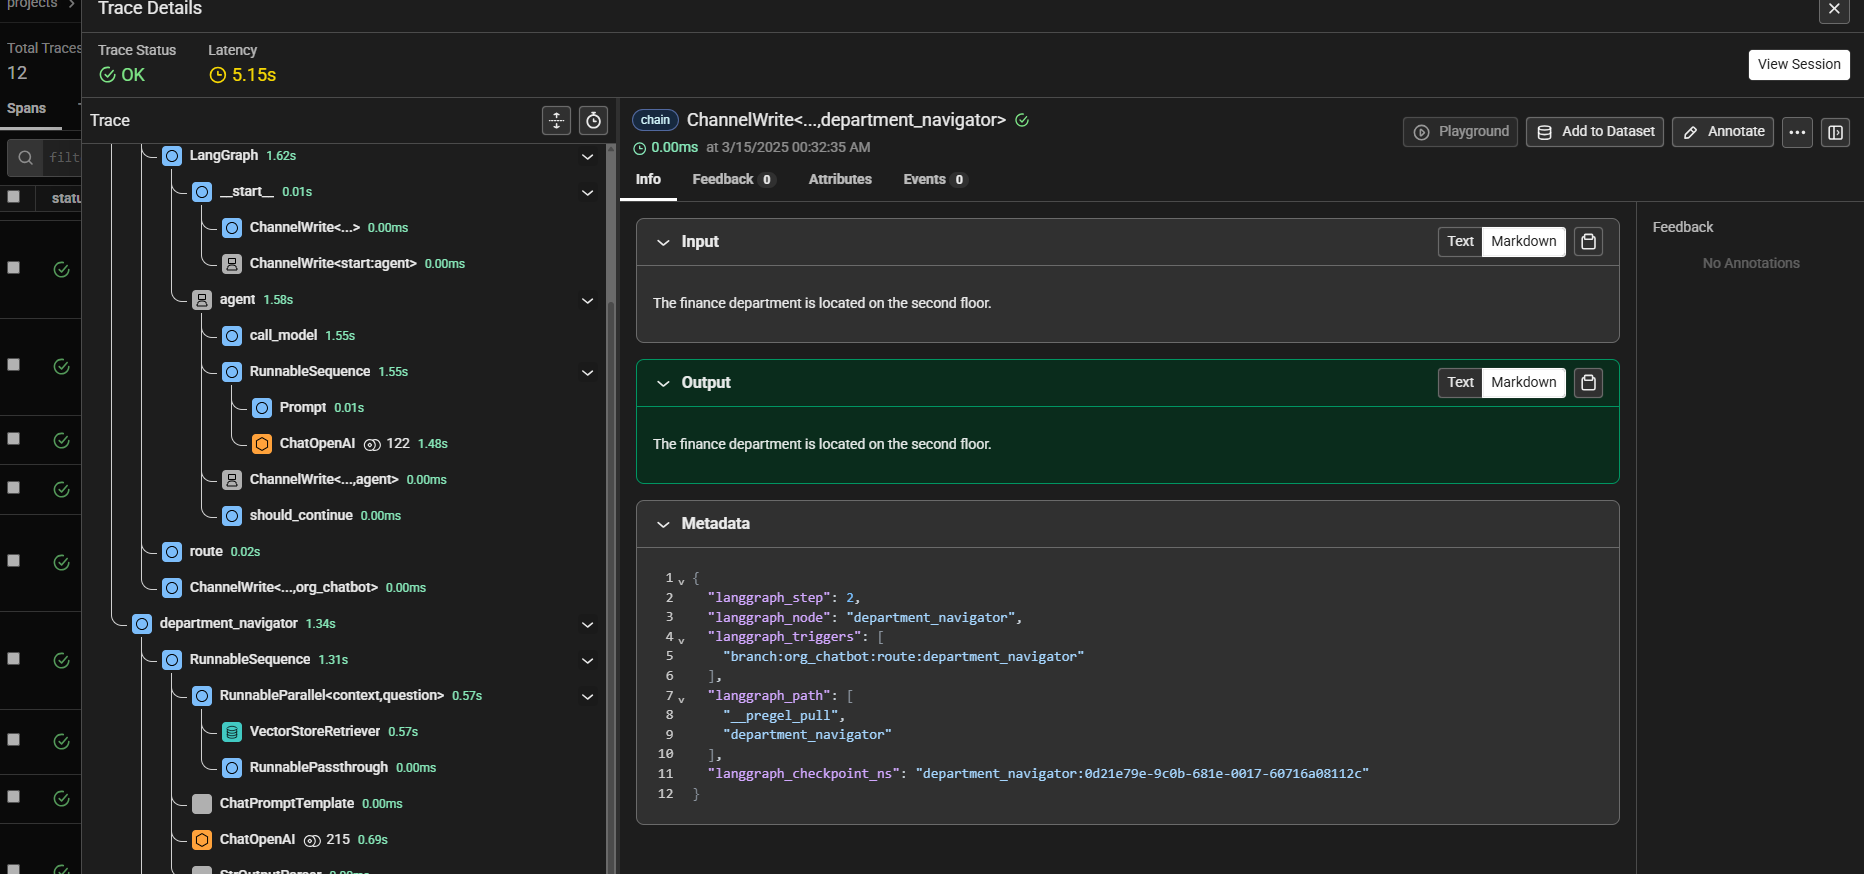

**Evaluation of Agent workflow**

Organisation chatbot agent's output will be evaluated by other LLMs as the judge through Phoenix's Tool calling and RAG evaluators 

**1.) LLM Tool calling evaluation**

In [19]:
import phoenix as px
from phoenix.evals import (
    TOOL_CALLING_PROMPT_TEMPLATE, 
    llm_classify,
    OpenAIModel
)
from openinference.instrumentation import suppress_tracing
from phoenix.trace import SpanEvaluations
from phoenix.trace.dsl import SpanQuery

In [20]:
print(TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

In [21]:
query = SpanQuery().where(
    # Filter for the `LLM` span kind.
    # The filter condition is a string of valid Python boolean expression.
    "span_kind == 'LLM'",
).select(
    question="input.value",
    tool_call="llm.tools"
)

# The Phoenix Client can take this query and return the dataframe.
tool_calls_df = px.Client().query_spans(query, 
                                        project_name="default", 
                                        timeout=None)
tool_calls_df = tool_calls_df.dropna(subset=["tool_call"])

tool_calls_df.head()


,question,tool_call
context.span_id,,
f1d00ae4b65929f8,"{""messages"": [{""content"": ""\n You are an ...","[{'tool': {'json_schema': '{""type"": ""function""..."
d998563f936e33e4,"{""messages"": [{""content"": ""\n You are an ...","[{'tool': {'json_schema': '{""type"": ""function""..."
86b69c62f05187e0,"{""messages"": [{""content"": ""\n You are an ...","[{'tool': {'json_schema': '{""type"": ""function""..."


In [22]:
tools = """
{
  "type": "function",
  "function": {
    "name": "get_employees",
    "description": "Gets the employees list.",
    "parameters": {
      "properties": {},
      "type": "object"
    }
  }
}
"""

In [23]:
import json
with suppress_tracing():
    tool_call_eval = llm_classify(
        dataframe = tool_calls_df,
        template = TOOL_CALLING_PROMPT_TEMPLATE.template[0].template.replace("{tool_definitions}", 
                                                                 json.dumps(tools).replace("{", '"').replace("}", '"')),
        rails = ['correct', 'incorrect'],
        model=OpenAIModel(model="gpt-4o"),
        provide_explanation=True
    )

tool_call_eval['score'] = tool_call_eval.apply(lambda x: 1 if x['label']=='correct' else 0, axis=1)

tool_call_eval.head()

C:\Users\thisi\AppData\Local\Temp\ipykernel_4460\1640787153.py:3: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  tool_call_eval = llm_classify(
🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.
llm_classify |██████████████████████████████████████████████████████████████| 3/3 (100.0%) | ⏳ 00:04<00:00 |  1.64s/it


,label,explanation,exceptions,execution_status,execution_seconds,score
context.span_id,,,,,,
f1d00ae4b65929f8,incorrect,The question is about the location of the fina...,[],COMPLETED,1.745893,0
d998563f936e33e4,correct,"The question is about the number of employees,...",[],COMPLETED,1.601645,1
86b69c62f05187e0,correct,The question asked about the number of employe...,[],COMPLETED,1.557497,1


*Explanation of the Tool calling assessment*

In [31]:
tool_call_eval["explanation"][0]

C:\Users\thisi\AppData\Local\Temp\ipykernel_4460\3379765375.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tool_call_eval["explanation"][0]


'The question is about the location of the finance department, which should be routed to the "department_navigator" agent according to the rules provided. The tool called, "get_employees", is meant for questions about employees and their reporting structure, not for department locations.'

In [32]:
tool_call_eval["explanation"][1]

C:\Users\thisi\AppData\Local\Temp\ipykernel_4460\2801487326.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tool_call_eval["explanation"][1]


"The question is about the number of employees, which falls under the category of questions about employees and their reporting structure. According to the rules, such questions should be addressed by calling the 'get_employees' tool. The tool called matches this requirement, as it is designed to get the employees list."

**2.) LLM RAG Evaluation**

In [24]:
from phoenix.session.evaluation import get_retrieved_documents

retrieved_documents_df = get_retrieved_documents(px.active_session())
retrieved_documents_df

context.trace_id  \
context.span_id  document_position                                     
94837c64831607c3 0                  b45897b5404abd930f0f1c2e218e3cb8   
                 1                  b45897b5404abd930f0f1c2e218e3cb8   
                 2                  b45897b5404abd930f0f1c2e218e3cb8   
                 3                  b45897b5404abd930f0f1c2e218e3cb8   

                                                                   input  \
context.span_id  document_position                                         
94837c64831607c3 0                  where is finance department located?   
                 1                  where is finance department located?   
                 2                  where is finance department located?   
                 3                  where is finance department located?   

                                                                         reference  
context.span_id  document_position                                                  
94837c64831607c3 0                          Finance is located on the second floor  
                 1                                HR is located on the first floor  
                 2                         Marketing is located on the fifth floor  
                 3                  Data & Analytics is located on the third floor

In [25]:
import pandas as pd
from phoenix.evals import (
    OpenAIModel, 
    RelevanceEvaluator,
    run_evals,
)

relevance_evaluator = RelevanceEvaluator(OpenAIModel(model_name="gpt-4-turbo-preview"))
retrieved_documents_relevance_df = run_evals(
    evaluators=[relevance_evaluator],
    dataframe=retrieved_documents_df,
    provide_explanation=True,
    concurrency=1,
)[0]

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


🐌!! If running inside a notebook, patching the event loop with nest_asyncio will allow asynchronous eval submission, and is significantly faster. To patch the event loop, run `nest_asyncio.apply()`.
run_evals |█████████████████████████████████████████████████████████████████| 4/4 (100.0%) | ⏳ 00:21<00:00 |  5.28s/it


In [26]:
retrieved_documents_relevance_df

label  score  \
context.span_id  document_position                     
94837c64831607c3 0                   relevant      1   
                 1                  unrelated      0   
                 2                  unrelated      0   
                 3                  unrelated      0   

                                                                          explanation  
context.span_id  document_position                                                     
94837c64831607c3 0                  The question asks for the location of the fina...  
                 1                  The question asks for the location of the fina...  
                 2                  The question asks for the location of the fina...  
                 3                  The question asks for the location of the fina...

*Explanation of the RAG assessment*

In [28]:
retrieved_documents_relevance_df["explanation"][0]

C:\Users\thisi\AppData\Local\Temp\ipykernel_4460\180587785.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retrieved_documents_relevance_df["explanation"][0]


'The question asks for the location of the finance department. The reference text directly answers this by stating that "Finance is located on the second floor." This information is directly relevant to the question as it provides the specific location of the finance department, which is what the question seeks. Therefore, the reference text contains information that can help answer the question.'

In [29]:
retrieved_documents_relevance_df["explanation"][1]

C:\Users\thisi\AppData\Local\Temp\ipykernel_4460\792467564.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  retrieved_documents_relevance_df["explanation"][1]


"The question asks for the location of the finance department. The reference text provides information about the location of the HR department, not the finance department. Therefore, the reference text does not contain information relevant to answering the specific question about the finance department's location."